# Notebook Summary

## Introduction

- Here we query data from different sources and apply NLP
- Data Sources
   - Gatsby: Their initial Standard to SOC 2020 SUG mappings
   - ONS: SOC 2020 SUG Title, Definitions and 
   - API: Get current SOC codes
   - IDS: Get Current SOC 2020 Assignments

## What is in this notebook

- Get data from API, Gatsby and ONS (Soc extension data)
- Prepare text to have w2v applied to it
- Apply Word2Vec comparison
   - Comparions done
      - Standard Title v SOC Jobs (Job or Title)
      - Typical Job Title (from API) v SOC Jobs (Job or Title)
      - Standard Overview vs. SOC Description
   - Note this part can take a long time (~4-5 hours)
   - So I use batches to help
      - We run the code for 50 ST codes then save to `nsfg_data`, then start next batch.
      - You can then pick the batches that need to be run.
      - Or just load batches by selecting `run_nlp = False`. Then all nlp running steps are skipped
       
- Run checks to see correlation and if feature is useful
    
      
## Output/Results

- File in format `f'nsfg_data\df_train_data_nlp__v{run_version}.csv'`
 - This contains data for next stage

## Sharepoint Set-up

- To run this you will need to need files from sharepoint
   - Specifically you need to place files from `SOC Codes\soc_code_extensions\datasets` in `path_soc`
- Laurie thinks the easiest way to do this is via syncing sharepoint to your local
   -  You can sync the onedrive by clicking on the 3 steps in this screenshot
   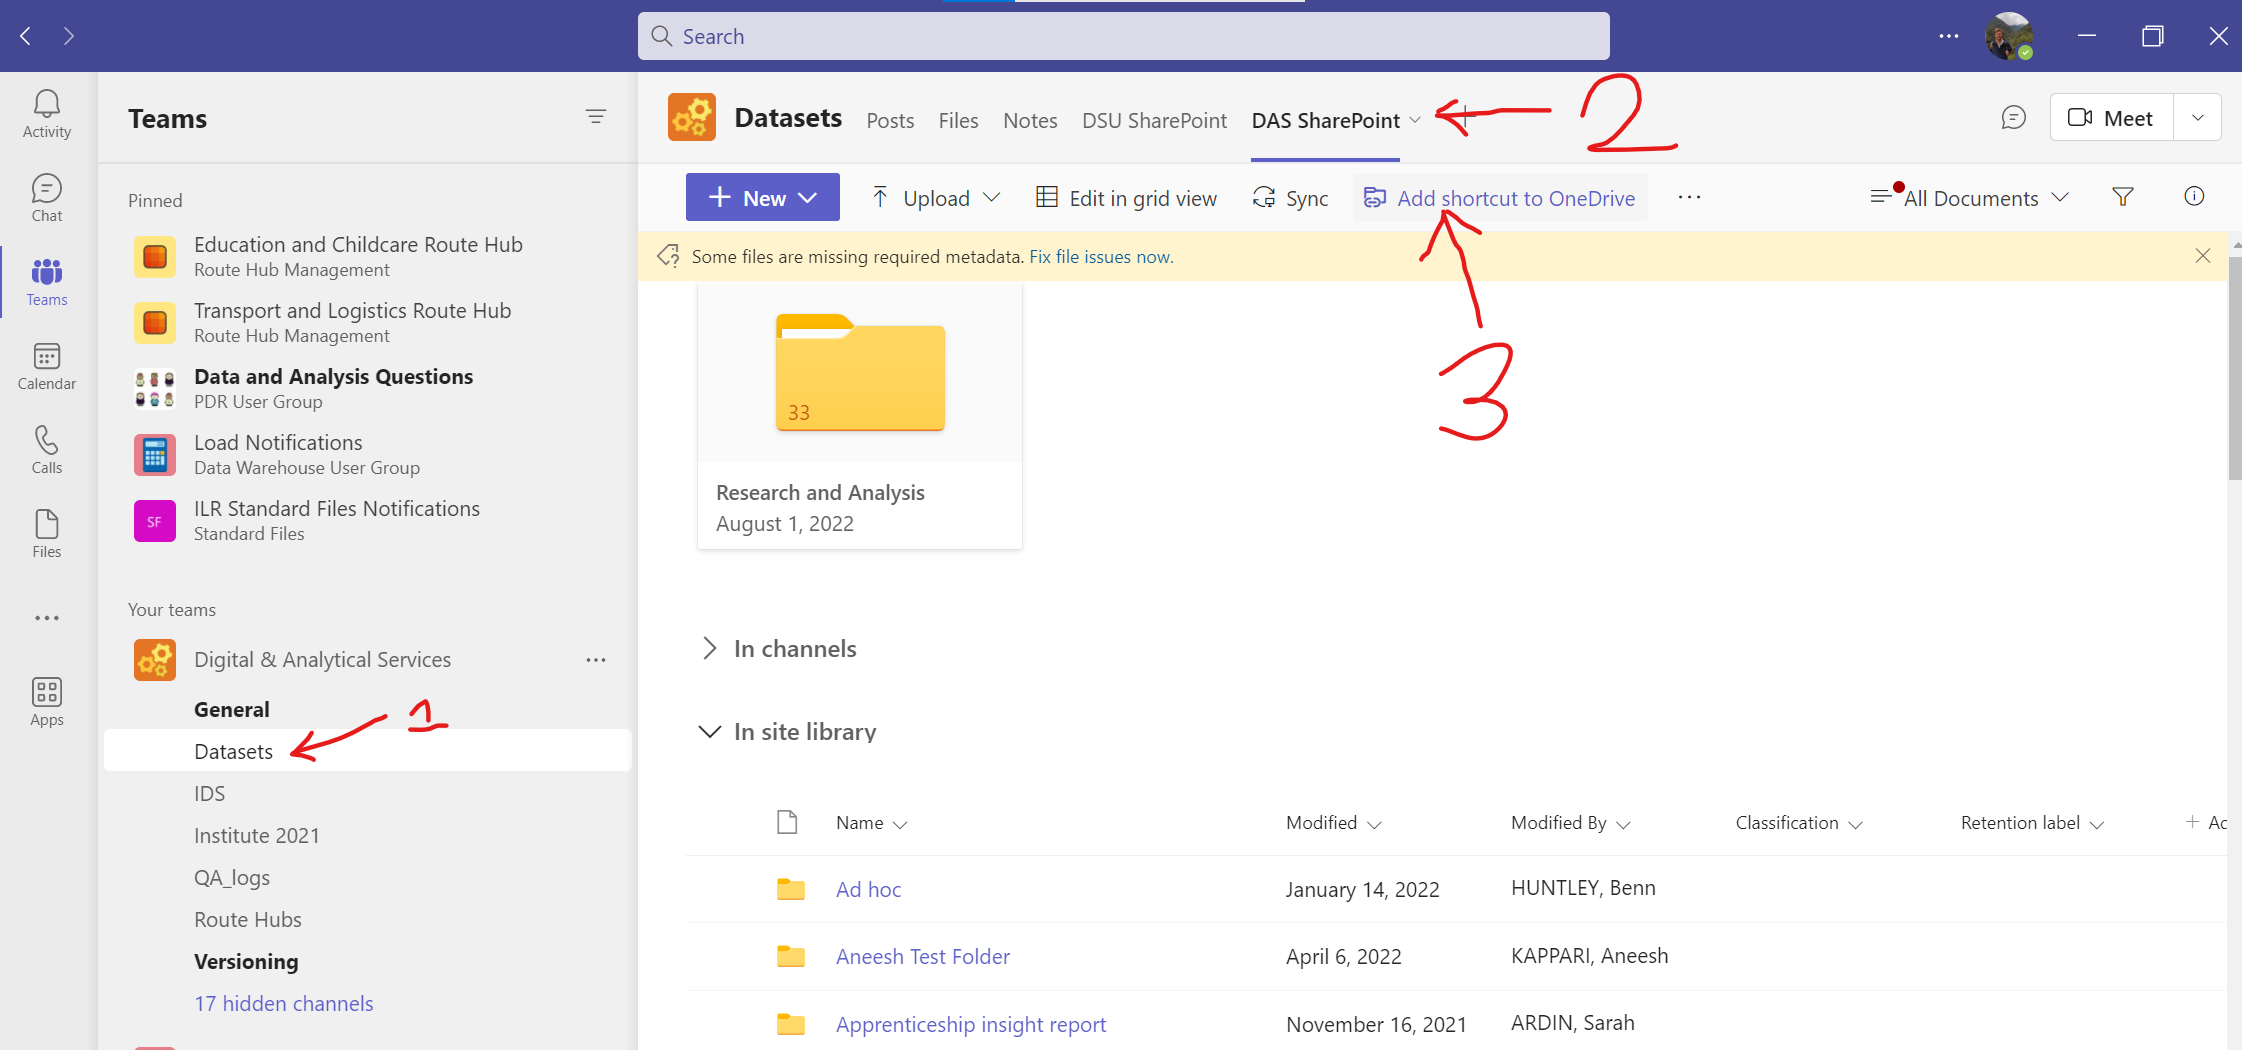


   - You (and your jupyter notebooks) can now read all files on sharepoint and write to there! 🎉
   - Then edit `path_dsdst` below, so it now points to your linke to one drive, it will probably be something similar


## Recommendation for Viewing Code

- The headings in this notebook follow Markdown convention i.e # means H1 and ## is H2
- I recommend adding a Table of Contents add on to see the structure of this notebook in the best way
- Here is a great package that can add a ToC to jupyter notebooks: https://github.com/minrk/ipython_extensions


# Notebook Setup

## Constants

In [ ]:
run_version = '4'
# Version 4 uses 
# - Updated SOC 2020 SUG codes emailed by Michela from ONS (202302_soc2020_ext_job_titles_data.csv) matching ones used by Gatsby
# - SOC 2020 Extracted from IDS to csv, which means will be robust to after deployment.
# Version 3 is tracks standard version better in data and adds route
# Version 2 is using gatsby 2.4

In [ ]:
## Things for running nlp
run_nlp = False

batch_size = 50

run_batch_start = 0
run_batch_end = None

load_batch_start = 0
load_batch_end = None


## Regular Imports

In [ ]:
### Imports 
import os
import sys
from pathlib import Path
import datetime

import numpy as np
import math
from scipy import stats

import pandas as pd
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## My Imports

In [ ]:
# Add Path of where you have imported my functions
current_path = os.getcwd()
functions_path = Path(current_path, '..', 'Functions')
sys.path.append(str(functions_path))

In [ ]:
## Pandas functions
import laurie_pandas_functions as pd_funcs
from laurie_pandas_functions import display_full

## Matplotlib funcs
import laurie_plotting_functions as plot_funcs
from laurie_plotting_functions import get_ax, force_ax_grid

In [ ]:
## Useful when developing your functions
from importlib import reload  
reload(pd_funcs)
reload(plot_funcs)

In [ ]:
def run_ls_on_path(path):
    """
    Run ls on a path in jupyter and display to notebook
    Can't be imported as uses cell magic
    Args: path (pathlib.WindowsPath): path created by pathlib
    """
    userhome = os.path.expanduser("~")
    reformatted_path = ('\"' + str(path).replace('\\\\', '\"/\"') + '\"').replace('\"~\"','~').replace('~', userhome)
    print(f'$ ls {path}')
    !ls {reformatted_path}
    print('\n')

## Django Setup
- IDS is not currently used!
- But should replace Gatsby when SUG model is deployed

In [ ]:
## Place the path to IDS here, as we can use it to get access to some of the IDS goodies.
userhome = os.path.expanduser("~")
ids_path = os.path.join(userhome, 'Programming','ids','S129-Institute-Data-System') ## This is for Laurie's path to IDS

In [ ]:
from laurie_django_functions import connect_to_ids_django
connect_to_ids_django(ids_path)

## Plotting Setup

In [ ]:
### Colours
blue =  '#79a5f7'
red  =  '#ff9696'
green=  '#9ebd9e'
sns_colours = sns.color_palette()

### Make the plots a nice size
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          'figure.titlesize':'x-large'}
pylab.rcParams.update(params)

# Get Data
- Read the csvs from the paths


## Path to SOC data
- To get this to work you will need add sharepoint locally, see above

In [ ]:
path_dsdst = Path('~', 'OneDrive - Department for Education', 'Documents - DSDST')
path_soc = Path(path_dsdst, 'SOC Codes')
path_soc_data = Path(path_soc, 'soc2020_subunit_groups', 'datasets')


In [ ]:
data_soc2020_ids_export = '2023_03_01' # Date of export to use. 
path_soc2020_export = Path(path_soc, 'ids_soc2020_code_exports', f'{data_soc2020_ids_export}_soc2020_ids_export_legacy.csv')

## Gatsby

In [ ]:
path_data_map_gatsby = Path(path_soc_data, 'standard_to_soc_ext_map_202302.csv')
df_map_gatsby_raw = pd.read_csv(path_data_map_gatsby, encoding='latin_1')

In [ ]:
df_map_gatsby_raw.loc[lambda df: df['standard_code'] == 'ST0574'].sort_values('match_rank')

In [ ]:
df_map_gatsby_raw.head(3).T

In [ ]:
df_map_gatsby = (
    df_map_gatsby_raw[['standard_code', 'soc_2020_ext_sug_code', 'match_rank']]
    .rename(columns={'soc_2020_ext_sug_code': 'soc_2020_ext_code'})
    .assign(soc_2020_ext_code=lambda df: df['soc_2020_ext_code'].str.strip())
)

## ONS
- Get SOC Extension Code Detail

In [ ]:
path_data_job_titles = Path(path_soc_data, '202302_soc2020_ext_job_titles_data.csv')

In [ ]:
df_soc_job_titles_raw = pd.read_csv(path_data_job_titles)

In [ ]:
df_soc_job_titles = df_soc_job_titles_raw.rename(columns={'job_title': 'soc_job'})

In [ ]:
df_soc_title_as_job_title = (
    df_soc_job_titles
    .drop('soc_job', axis=1)
    .drop_duplicates()
    .assign(soc_job=lambda df: df['soc_2020_ext_title'])
    .assign(soc_job_is_soc_title=True)
)

In [ ]:
df_soc_job_titles_append = (
    pd.concat([df_soc_job_titles, df_soc_title_as_job_title])
    .assign(soc_job_is_soc_title=lambda df: df['soc_job_is_soc_title'].fillna(False))
)

In [ ]:
df_soc_job_titles_append.loc[lambda df: df['soc_2020_ext_code'] == '2125/99']

## API

In [ ]:
api_url = 'https://www.instituteforapprenticeships.org/api/apprenticeshipstandards'

In [ ]:
import requests

def query_url_to_df(url):
    response = requests.get(url)
    result = response.json()
    data = pd.DataFrame.from_records(result)
    return data

In [ ]:
df_api_raw = query_url_to_df(api_url)

## IDS - Legacy
- Get SOC 2020 Codes set before any deployment of new SUG 2020 data

In [ ]:
df_ids_standards_raw = pd.read_csv(path_soc2020_export)

In [ ]:
## Reshape slightly
cols_to_keep = [
    'standard_code',
    'ref_no',
    'ids_soc_2020_code',
    'ids_soc_2020_rationale',
    'version',
]
df_ids_standards = (
    df_ids_standards_raw
    .rename(columns={
        'soc2020_code': 'ids_soc_2020_code',
        'soc2020_rationale': 'ids_soc_2020_rationale',
    }
    )
    .assign(version=lambda df: df['ref_no'].str.split('_V').str[1].astype(float))
    [cols_to_keep]

)

In [ ]:
df_ids_standards.head(3).T

# Process Data

## API Standards

In [ ]:
def extract_option_titles(api_data):
    """
    Stolen and adapted from: https://dev.azure.com/dfe-ssp/_git/S129-Institute-Data-System?path=/data/validation/data_inconsistencies.py&version=GBmaster&line=79&lineEnd=126&lineStartColumn=1&lineEndColumn=1&lineStyle=plain&_a=contents
    
    option titles are an object column which need to be extracted into a string with all the
    options joined. Where the structured option titles are missing, the UNstructured option titles
    will be used instead

    Args:
        api_data (pd.DataFrame): apprenticeship standards processed by process_api_data()

    Returns:
        pd.DataFrame: processed apprenticeship standards with string column for option titles
    """
    options_dict = {'standard_code': [], 'version': [], 'option_titles': []}

    for i in api_data.index:
        options_dict['standard_code'].append(api_data['standard_code'][i])
        options_dict['version'].append(api_data['version'][i])

        if api_data['options'][i]:
            temp = []
            for y in range(len(api_data['options'][i])):
                temp.append(api_data['options'][i][y]['title'].strip())
            temp.sort()
            options_dict['option_titles'].append('; '.join(temp))
        else:
            options_dict['option_titles'].append(pd.NA)

    options_df = pd.DataFrame(options_dict)

    api_data_with_option_titles = pd.merge(
        left=api_data, right=options_df, on=['standard_code', 'version'], how='left'
    )

    api_data_with_option_titles[
        'sort_unstructured_options'
    ] = api_data_with_option_titles['options_unstructured_template'].apply(sorted)

    api_data_with_option_titles[
        'options_pseudo_structured'
    ] = api_data_with_option_titles['sort_unstructured_options'].map(
        lambda x: '; '.join([y.strip() for y in x])
    )

    api_data_with_option_titles['option_titles'] = api_data_with_option_titles[
        'option_titles'
    ].fillna(api_data_with_option_titles['options_pseudo_structured'])
    
    
    api_data_with_option_titles = api_data_with_option_titles.drop(['options_pseudo_structured', 'sort_unstructured_options'], axis=1)

    return api_data_with_option_titles


In [ ]:
df_api_standards_snaked = pd_funcs.apply_snake_case_to_df(df_api_raw)

In [ ]:
api_to_standard_renamer = {
    'reference_number': 'standard_code',
    'version': 'version',
    'title': 'standard_title',
    'status': 'status',
    'level': 'level',
    'typical_job_titles': 'typical_job_titles',
    'overview_of_role': 'standard_overview',
    'route': 'route',
    'options': 'options',
    'options_unstructured_template': 'options_unstructured_template',
    'core_and_options': 'is_core_and_options',
}

In [ ]:
df_api_standards_renamed = (
    df_api_standards_snaked
    .rename(columns=api_to_standard_renamer)
    [api_to_standard_renamer.values()]
    .assign(version=lambda df: df['version'].astype(float))
)

In [ ]:
df_api_standards_filtered = (
    df_api_standards_renamed
    .loc[lambda df: df['status'].isin(['Approved for delivery', 'In development'])]
    .sort_values('standard_code')
)

In [ ]:
df_api_standards_w_options = (
    extract_option_titles(df_api_standards_filtered)
    .drop(['options', 'options_unstructured_template'], axis=1)
)

In [ ]:
assert df_api_standards_filtered.shape[0] == df_api_standards_w_options.shape[0] 

In [ ]:
data_with_id = pd_funcs.count_n_rows_per_id(df_api_standards_w_options, 'standard_code')
data_with_id.loc[lambda df: df['n_rows_per_id'] > 1]

## Add Current SOC code

In [ ]:
df_standards = (
    df_api_standards_w_options
    .merge(
        df_ids_standards,
        on=['standard_code', 'version'],
        how='left'
    )
)

In [ ]:
n_standards = df_standards.shape[0]
n_standards_filtered = df_api_standards_filtered.shape[0]

assert n_standards == n_standards_filtered, f'df_api_standards has {n_standards} rows where df_api_standards_filtered has {n_standards_filtered} rows'

## Job Titles

In [ ]:
df_standards['n_typical_job_titles'] = df_standards['typical_job_titles'].str.len()
pd_funcs.agg_df_by_cols(df_standards, 'n_typical_job_titles', display_df=True, sort_by_cols=True, do_total=False)

In [ ]:
df_standards_typical_job_titles = (
    df_standards
    .explode('typical_job_titles')
    .rename(columns={'typical_job_titles': 'standard_typical_job_title'})
    .loc[lambda df: ~df['standard_typical_job_title'].isna()]
    [['standard_code', 'version', 'standard_typical_job_title']]
    .reset_index(drop=True)
)

df_standards_typical_job_titles

In [ ]:
a = pd_funcs.count_n_rows_per_id(df_standards_typical_job_titles, ['standard_code', 'standard_typical_job_title'])
a.loc[lambda df: df['n_rows_per_id'] > 1]

## SOC Description

In [ ]:
df_soc_descriptions = (
    df_soc_job_titles[['soc_2020_ext_code', 'soc_2020_ext_description']]
    .drop_duplicates()
    .reset_index(drop=True)
)

# NLP

## Prep Words

### NLP Functions

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim

In [ ]:
WORD2VEC_FILEPATH = Path(ids_path, '..', 'www', 'data', 'nlp', 'GoogleNews-vectors-negative300.bin.gz')
US_UK_DICT_FILEPATH = Path(ids_path, 'ifa_standards_rms', 'exports', 'data', 'uk_us_dictionary.txt')

In [ ]:
def get_pretrained_word2vec():
    """
    Get the word embedding vectors from the Word2Vec model pre-trained on
    Google News. The trained word vectors are stored in a KeyedVectors instance
    in model.wv
    """
    w2v_filepath = WORD2VEC_FILEPATH

    w2v_model = gensim.models.KeyedVectors.load_word2vec_format(
        w2v_filepath, unicode_errors='ignore', binary=True,
    )

    return w2v_model

In [ ]:
def get_uk_us_dict():
    """
    Takes a text file containing a mapping of UK to US spellings of words and
    converts it into a Python dictionary.
    """
    with open(US_UK_DICT_FILEPATH) as dict_file:
        us_uk_dict = dict([line.split() for line in dict_file])
    return us_uk_dict

In [ ]:
def translate_uk_to_us_words(text, translation_dict):
    """
    Takes the text and replaces UK words with their US spellings
    """
    for uk_word, us_word in translation_dict.items():
        text = text.replace(uk_word, us_word)
    return text

In [ ]:
def get_words_for_w2v_model(text, w2v_model, spelling_dict):
    """
    This function takes the text and converts it into a list of words to use in
    the similarity calculation. Note that stopwords are removed here as the w2v
    model does not include some of these. Also it translates words to their US
    spelling (where necessary) due to the model being trained on US English
    (e.g. 'organisation' does not appear because in the w2v model it appears
    as 'organization').
    """
    tokens = word_tokenize(str(text))
    
    
    tokens_for_w2v_model = []
    
    for token in tokens:

        token = token.lower()
        token = translate_uk_to_us_words(token, spelling_dict)
        
        if token.isalpha():
            if token not in stopwords.words('english'):
                if token in w2v_model:
                    tokens_for_w2v_model.append(token)
    
    return tokens_for_w2v_model

In [ ]:
w2v_model = get_pretrained_word2vec()

In [ ]:
spelling_dict = get_uk_us_dict()

### prepare_text_column func

In [ ]:
def prepare_text_column(data, col, spelling_dict=spelling_dict, w2v_model=w2v_model, suffix='for_w2v'):
    
    def this_get_words_for_w2v_model(text):
        return get_words_for_w2v_model(text, w2v_model, spelling_dict) 

    if isinstance(col, list):        
        for c in col:
            data = prepare_text_column(data, c, spelling_dict, w2v_model)
        
    elif isinstance(col, str):    
        new_col = f'{col}_{suffix}'
        data[new_col] = data[col].astype(str).apply(this_get_words_for_w2v_model)

    else:
        raise TypeError('Col must be of type str or list of str')

    return data

In [ ]:
from pandas.testing import assert_frame_equal

In [ ]:
def test_prepare_text_column():
    df_input = pd.DataFrame(
        {
            'text': ['Hello Organisation', 'a hello world 2', 'HGV Driver'],
            'numbers': [1, 2, 3]
            
        }
    )
    
    df_expected = df_input.assign(text_for_w2v=[['hello', 'organization'], ['hello', 'world'], ['driver']])
    
    df_results = prepare_text_column(df_input, 'text')
    
    len(df_results)
    
    assert_frame_equal(df_results, df_expected)
   
test_prepare_text_column()

In [ ]:
def test_prepare_text_columns():
    df_input = pd.DataFrame(
        {
            'text': ['Hello Organisation'],
            'text_2': ['hello world 2'],
            'numbers': [1]
            
        }
    )
    
    df_expected = df_input.assign(
        text_for_w2v=[['hello', 'organization']],
        text_2_for_w2v=[['hello', 'world']],
    )
    
    df_results = prepare_text_column(df_input, ['text', 'text_2'])
        
    assert_frame_equal(df_results, df_expected)
   
test_prepare_text_columns()

## App Prep Words Function

In [ ]:
df_standards.columns

In [ ]:
df_standards = prepare_text_column(df_standards, ['standard_title', 'standard_overview'])

In [ ]:
df_standards_typical_job_titles = prepare_text_column(df_standards_typical_job_titles, 'standard_typical_job_title') 

In [ ]:
df_soc_job_titles_append = prepare_text_column(df_soc_job_titles_append, 'soc_job') 

In [ ]:
df_soc_descriptions = prepare_text_column(df_soc_descriptions, 'soc_2020_ext_description') 

In [ ]:
df_soc_descriptions.head(3)

## NLP Comparison

### Comp Funcs

In [ ]:
def run_comparisons(data, x, y, col_comparison_score, suffix='for_w2v', w2v_model=w2v_model):
    
    x_words = f'{x}_{suffix}'
    y_words = f'{y}_{suffix}'
    
    cols_match = (data[x] == data[y])
    
    words_no_length = (data[x_words].str.len() == 0) | (data[y_words].str.len() == 0)
    
    run_comparison = (~cols_match) & (~words_no_length)
    
    data[col_comparison_score] = 0
    data.loc[cols_match, col_comparison_score] = 1
    data.loc[run_comparison, col_comparison_score] = (
        data.loc[run_comparison].apply(lambda row: w2v_model.n_similarity(row[x_words], row[y_words]), axis=1)
    )
    
    return data

In [ ]:
def get_best_match(df_a, df_b, col_a, col_b, id_cols=['standard_code', 'soc_2020_ext_code', 'soc_2020_ext_title'], col_comparison_score=None):
    
    df_merge = pd.merge(
        df_a.assign(fake_key=1),
        df_b.assign(fake_key=1),
        on='fake_key',
    ).drop('fake_key', axis=1)
    
    df_merge = (
        run_comparisons(df_merge, col_a, col_b, col_comparison_score=col_comparison_score)
    )
    
    df_merge = (
        df_merge
        .sort_values(col_comparison_score, ascending=False)
        .drop_duplicates(id_cols, keep='first')
        .reset_index(drop=True)
        [id_cols + [col_a, col_b, col_comparison_score]]
    )
    
    for c in [col_a, col_b]:
        df_merge[c] = df_merge[c].str.capitalize()

    return df_merge


### Apply in Loop

In [ ]:
## Create batches
batch = []
batches = []
unique_st_codes = df_standards['standard_code'].unique()
for j, st_code in enumerate(unique_st_codes):
    
    count = j+1
    
    batch.append(st_code)
    
    if ((count) % batch_size == 0) or (count == len(unique_st_codes)):
        print(f'{count} Done')
        batches.append(batch)
        batch = []
        
print(f'Number of batches = {len(batches):,.0f}')
print(f'Size of first batch = {len(batches[0]):,.0f}')

In [ ]:
def get_batch_file_name(batch_i, batch_size, run_version=run_version):
    return f'nsfg_batches/df_nlp_comparison__version_{run_version}_batch_size_{batch_size}_batch_i_{batch_i:02.0f}.csv'

In [ ]:
%%time
n_batches = len(batches)
batch_size = len(batches[0])
run_batch_end = run_batch_end or n_batches

if run_nlp:
    os.makedirs('nsfg_batches', exist_ok=True)
    
    i = 0
    
    for i in range(run_batch_start, run_batch_end):
        st_codes = batches[i]
        print(i, st_codes)
        these_df_standards = df_standards.loc[lambda df: df['standard_code'].isin(st_codes)]
        these_df_standards_typical_job_titles = df_standards_typical_job_titles.loc[lambda df: df['standard_code'].isin(st_codes)]
        
        this_df_title_comparison = get_best_match(
            these_df_standards,
            df_soc_job_titles_append,
            'standard_title',
            'soc_job',
            col_comparison_score='score_soc_job_match_standard_title'
        )
    
        this_df_typical_job_title_comparison = get_best_match(
            these_df_standards_typical_job_titles,
            df_soc_job_titles_append,
            'standard_typical_job_title',
            'soc_job',
            col_comparison_score='score_soc_job_match_typical_job'
        )
    
        this_df_comparison = (
            this_df_title_comparison
            .merge(
                this_df_typical_job_title_comparison, 
                how='left',
                on=['standard_code', 'soc_2020_ext_code', 'soc_2020_ext_title'],
                suffixes=('_matches_standard_title', '_matches_typical_job')
            )
        )
        
        this_df_comparison = (
            this_df_comparison
            .merge(
                df_standards[['standard_code', 'version', 'standard_overview', 'standard_overview_for_w2v']],
                on='standard_code', 
                how='left',
            )
            .merge(
                df_soc_descriptions,
                on='soc_2020_ext_code', 
                how='left',
            )
        )
        this_df_comparison = run_comparisons(this_df_comparison, 'standard_overview', 'soc_2020_ext_description', 'score_overview')
        this_df_comparison = this_df_comparison.drop(['soc_2020_ext_description_for_w2v', 'standard_overview_for_w2v'], axis=1)
        
        this_df_comparison = (
            this_df_comparison
            .assign(score=lambda df: 
                df['score_soc_job_match_standard_title'].fillna(0) + 
                df['score_soc_job_match_typical_job'].fillna(0) +
                df['score_overview'].fillna(0)
            )
            .sort_values('score', ascending=False)
        )
    
        this_df_comparison.to_csv(get_batch_file_name(i, batch_size))
                    
    print(f'Done {i+1} batches')

In [ ]:
load_batch_end = load_batch_end or n_batches

list_df_comparison = []

for i in range(load_batch_start, load_batch_end):

    file_name = get_batch_file_name(i, batch_size)
    try:
        this_df_comparison = pd.read_csv(file_name)
        
    except:
        print(f'Couldn\'t find file at {file_name}')
        continue
        
    list_df_comparison.append(this_df_comparison)
        
df_comparison = pd.concat(list_df_comparison)

df_comparison = df_comparison.assign(score=lambda df: 
    df['score_soc_job_match_standard_title'].fillna(0) + 
    df['score_soc_job_match_typical_job'].fillna(0) +
    df['score_overview'].fillna(0)
)

# Post-process data

## Label the comparisons with Gatsby

In [ ]:
df_train_labelled = (
    df_comparison
    .merge(df_map_gatsby, on=['standard_code', 'soc_2020_ext_code'], how='left')
)

## Add on missing columns

In [ ]:
df_soc_to_merge_on = (
    df_soc_job_titles
    [['soc_2020_ext_code', 'soc_2020_code', 'soc_2020_title', 'soc_2020_major_group', 'soc_2010_code']]
    .drop_duplicates(subset='soc_2020_ext_code')
)

In [ ]:
df_soc_descriptions

In [ ]:
df_train_data = (
    df_train_labelled
    .merge(
        df_standards[['standard_code', 'version', 'status', 'level', 'ids_soc_2020_code', 'ids_soc_2020_rationale', 'route', 'is_core_and_options', 'option_titles']],
        on=['standard_code', 'version'],
        how='left',
    )
    .merge(
        df_soc_to_merge_on,
        on='soc_2020_ext_code',
        how='left',
    )
    .drop('Unnamed: 0', axis=1)
)

In [ ]:
df_train_data['soc_2020_matches_previous_assignment'] = np.where(
    df_train_data['ids_soc_2020_code'].isna(), -1, (df_train_data['ids_soc_2020_code'].astype(float) == df_train_data['soc_2020_code'].astype(float)).astype(int)
)

In [ ]:
assert df_train_data.shape[0] == df_train_labelled.shape[0], 'Merge to add label shouldn\'t add rows'


In [ ]:
_ = pd_funcs.count_n_rows_per_id(df_train_data, ['standard_code', 'version', 'soc_2020_ext_code'])

In [ ]:
_ = pd_funcs.count_n_rows_per_id(df_train_data, ['standard_code', 'soc_2020_ext_code'])

In [ ]:
df_map_gatsby.loc[lambda df: df['standard_code']=='ST0541'].loc[lambda df: df['soc_2020_ext_code']=='8112/00'].T

# Quick Analysis

## Create categories

In [ ]:
df_train_data['match_rank_category'] = df_train_data['match_rank'].fillna('Un-ranked')

df_train_data['match_rank_category'] = (
    np.where(
       df_train_data['match_rank_category'].isin([1.0, 2.0, 3.0, 'Un-ranked']),
       df_train_data['match_rank_category'],
       '> 3',
    )
)

pd_funcs.agg_df_by_cols(df_train_data, 'match_rank_category', display_df=True, do_total=False)

## Check if useful

In [ ]:
axes = get_ax(nrows=4, height=25)


for x, ax in zip(['score_soc_job_match_standard_title', 'score_soc_job_match_typical_job', 'score_overview', 'soc_2020_matches_previous_assignment'], axes):
    
    
    if x=='soc_2020_matches_previous_assignment':
        bins = np.linspace(-1, 1, 11)
    else: 
        bins = np.linspace(0, 1, 51)
        

    sns.histplot(
        df_train_data,
        x=x,
        stat='probability',
        common_norm=False,
        ax=ax,
        hue='match_rank_category',
        hue_order=[1.0, 2.0, 3.0, '> 3', 'Un-ranked'],
        bins=bins,
    )
    force_ax_grid(ax)


## Check Correlations

In [ ]:
## App title vs. typical jobs
axes = get_ax(ncols=3, nrows=2, width=14, height=12)
for i, c in enumerate([1.0, 2.0, 3.0, '> 3', 'Un-ranked']):
    
    ix = i % 3
    iy = int(np.floor(i/3))
    
    
    ax = axes[iy][ix]
    sns.scatterplot(
        data=df_train_data.loc[lambda df: df['match_rank_category']==c],
        x='score_soc_job_match_standard_title', 
        y='score_soc_job_match_typical_job',
        ax=ax,
    )
    ax.set(title=c)
    force_ax_grid(ax)

In [ ]:
## App title vs. overview
axes = get_ax(ncols=3, nrows=2, width=14, height=12)
for i, c in enumerate([1.0, 2.0, 3.0, '> 3', 'Un-ranked']):
    
    ix = i % 3
    iy = int(np.floor(i/3))
    
    ax = axes[iy][ix]

    sns.scatterplot(
        data=df_train_data.loc[lambda df: df['match_rank_category']==c],
        x='score_soc_job_match_standard_title', 
        y='score_overview',
        ax=ax,
    )
    ax.set(title=c)
    force_ax_grid(ax)

# Export to Data

In [ ]:
df_train_data = df_train_data.sort_values(['standard_code', 'score'], ascending=[True, False])

In [ ]:
df_train_data.sample(10).T

In [ ]:
os.makedirs('nsfg_data', exist_ok=True)
timestamp = datetime.datetime.today().strftime('%Y%m%d_%H%m')
export_file_name = Path('nsfg_data', f'df_train_data_nlp__v{run_version}.csv')
print(export_file_name)

In [ ]:
df_train_data.to_csv(export_file_name, index=False)